In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download vikashrajluhaniwal/fashion-images

Dataset URL: https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images
License(s): CC0-1.0
 97% 323M/335M [00:01<00:00, 260MB/s]
100% 335M/335M [00:01<00:00, 284MB/s]


In [4]:
!unzip -q fashion-images.zip

In [5]:
!ls data
# !ls data/Apparel/Boys/Images/images_with_product_ids

Apparel  fashion.csv  Footwear


In [6]:
!pip install -q faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 70.8 MB/s eta 0:00:00


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from transformers import CLIPModel, CLIPProcessor
import faiss
from torch.optim import AdamW
from torch.nn.functional import pad
from torch.nn import CrossEntropyLoss
from PIL import Image

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
device

'cuda'

In [45]:
model = CLIPModel.from_pretrained('openai/clip-vit-large-patch14').to(device)
processor = CLIPProcessor.from_pretrained('openai/clip-vit-large-patch14')

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
df = pd.read_csv('data/fashion.csv')
df.head()

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...


In [12]:
df.drop(columns=['ProductId', 'ImageURL'], axis=1, inplace=True)
df.head()

,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image
0,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg
1,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg
2,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg
3,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg
4,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg


In [13]:
row = df.iloc[2]

txt = row['ProductTitle'] + " " + row['Gender'] + " " + row['Category'] + " " + row['SubCategory'] + " " + row['ProductType'] + " " + row['Colour'] + " " + row['Usage']

txt

'Gini and Jony Girls Pretty Blossom Blue Top Girls Apparel Topwear Tops Blue Casual'

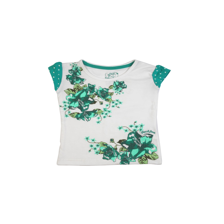

In [14]:
Image.open('data/Apparel/Girls/Images/images_with_product_ids/42419.jpg').resize((224, 224))

In [15]:
print(processor.tokenizer.model_max_length)

77


In [36]:
class AllProduct(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(f"data/{row['Category']}/{row['Gender']}/Images/images_with_product_ids/{row['Image']}").resize((224, 224))
        text = row['ProductTitle'] + " " + row['Gender'] + " " + row['Category'] + " " + row['SubCategory'] + " " + row['ProductType'] + " " + row['Colour'] + " " + row['Usage']
        inputs = self.processor(text=[text], images=image, return_tensors='pt', padding=True)

        return{
            'input_ids' : inputs['input_ids'].squeeze(0),
            'attention_mask' : inputs['attention_mask'].squeeze(0),
            'pixel_values' : inputs['pixel_values'].squeeze(0),
        }

    def __len__(self):
        return len(self.df)

In [37]:
dataset = AllProduct(df, processor)

In [38]:
sample = dataset[105]

print(sample['input_ids'].shape)
print(sample['attention_mask'].shape)
print(sample['pixel_values'].shape)

torch.Size([21])
torch.Size([21])
torch.Size([3, 224, 224])


In [39]:
len(dataset)

2906

In [40]:
processor.tokenizer.pad_token_id

49407

In [41]:
def custom_collate_func(batch):
    max_len = max([len(item['input_ids']) for item in batch])

    padded_input_ids = torch.stack([
        pad(item['input_ids'], (0, max_len - len(item['input_ids'])),
        value=processor.tokenizer.pad_token_id) for item in batch
    ])

    padded_attention_mask = torch.stack([
        pad(item['attention_mask'], (0, max_len - len(item['attention_mask'])),
        value=processor.tokenizer.pad_token_id) for item in batch
    ])

    pixel_values = torch.stack([item['pixel_values'] for item in batch])

    return{
        "input_ids" : padded_input_ids,
        "attention_mask" : padded_attention_mask,
        "pixel_values" : pixel_values
    }

In [42]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_func)

In [43]:
len(dataloader)

364

In [46]:
epochs = 3
optimizer = AdamW(model.parameters(), lr=5e-6)

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                        pixel_values=pixel_values)

        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds

        # Normalize
        image_embeds = image_embeds / image_embeds.norm(p = 2, dim = -1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p = 2, dim = -1, keepdim=True)

        # Contrastive loss
        logits_per_image = image_embeds @ text_embeds.T
        labels = torch.arange(len(image_embeds)).to(device)
        loss_i = CrossEntropyLoss()(logits_per_image, labels)
        loss_t = CrossEntropyLoss()(logits_per_image.T, labels)
        loss = (loss_i + loss_t) + 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataloader):.4f}")

Epoch 1/3 | Loss: 4.8912
Epoch 2/3 | Loss: 4.6973
Epoch 3/3 | Loss: 4.6756
